## Creating a Graphical Method

This is just the script to make the graphical method.  Honestly the more interesting part of this notebook is actaully the code for creating the figure which gives a pretty good script for making a complex matplotlib figure. 

Carter Francis | csfrancis@wisc.edu | 2024-01-13

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np


import hyperspy.api as hs
from scipy.ndimage import correlate1d, correlate, gaussian_filter, median_filter
from skimage.feature.template import match_template
from skimage.draw import disk
from sklearn.cluster import DBSCAN

from diffsims.generators.diffraction_generator import DiffractionGenerator
from orix.crystal_map import Phase
from orix.quaternion import Rotation
from utils import *

In [10]:
Al_Structure = Phase.from_cif("data/Al.cif")
rot = Rotation.from_euler([[0,0,45], [0,36,0]], degrees=True)
sim = CrystalSTEMSimulation(Al_Structure,
                      num_crystals=2,
                      crystal_size=20,
                      real_space_pixels=64,
                      k_range=1.2,
                      recip_space_pixels=128,
                      rotations=rot)

sim.random_inplane = np.array([0, np.pi/7])
sim.centers[0] = [25,25]
sim.centers[1] = [35,35]

sim.vectors, sim.coordinates, sim.real_space_vectors, sim.intensities = sim.get_nano_crystal_vectors()

In [15]:
arr = sim.make_4d_nano(num_electrons=1, radius=8)

In [16]:
s = hs.signals.Signal2D(arr)
s.axes_manager.signal_axes[0].offset=-1.2
s.axes_manager.signal_axes[1].offset=-1.2
s.axes_manager.signal_axes[1].scale=1.2/64
s.axes_manager.signal_axes[0].scale=1.2/64
#s.plot(vmax="95th")
s.set_signal_type("electron_diffraction")
filtered = s.filter(gaussian_filter,
                         sigma=(1,1,0,0))
template = filtered.template_match_disk(disk_r=8,
                                        subtract_min=False,
                                       show_progressbar=False)

pks = template.find_peaks(threshold_abs=0.3,
                          interactive=False,
                          show_progressbar=False, min_distance=5 )
from pyxem.signals.diffraction_vectors import DiffractionVectors
vect = DiffractionVectors.from_peaks(pks)
filt = vect.filter_magnitude(.01,1,show_progressbar=False )

flat = filt.flatten_diffraction_vectors()

            
flat = filt.flatten_diffraction_vectors()

cluster = DBSCAN(eps=1, min_samples=2)
lab = flat.cluster(cluster,columns=(0,1,2,3), column_scale_factors = (2,2,0.1,0.1),)
cluster2 = DBSCAN(eps=10, min_samples=2)
clust = lab.cluster_labeled_vectors(cluster2, columns=(0,1)) # only cluster in x,y

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 105.75 ms
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 210.90 ms
3 : Clusters Found!


In [17]:
points, poly = clust.to_markers(s, get_polygons=True)
offsets = points.kwargs["offsets"]
colors = points.kwargs["color"]
vert = poly.kwargs["verts"]
colors_by_index = poly.kwargs["color"]

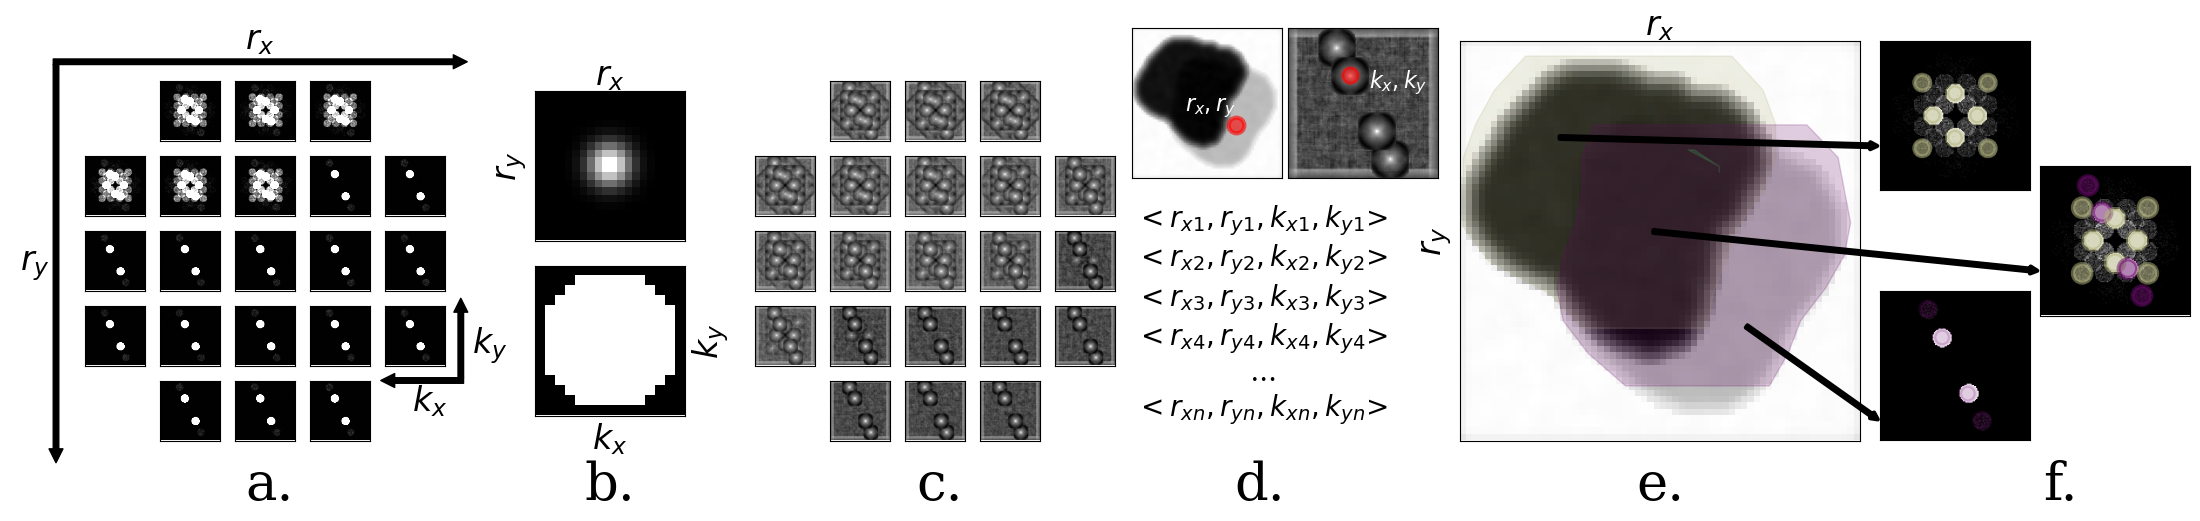

In [21]:
%matplotlib inline
from matplotlib.collections import PolyCollection, CircleCollection
fig = plt.figure(figsize=(10,5))

range_ax=fig.add_axes((.0,.05, .46,.85))
range_ax.axis("off")


x_line = FancyArrowPatch(posA=(0.088,.95), posB=(1,.95),mutation_scale=20, color="black")
y_line = FancyArrowPatch(posA=(0.1,.95), posB=(0.1,0),mutation_scale=20, color="black")

range_ax.add_patch(x_line)
range_ax.add_patch(y_line)

center=[42, 39]

for i in range(-4,4):
    for j in range(-4,4):
        if ((i)**2+(j**2))<8:
            ax = fig.add_axes(((i+3)*.075,j*.15+.4, 0.06,0.12))
            new_center = np.add(center, [i*2,-j*2])
            ax.imshow(arr[new_center[0],new_center[1]], vmax=10, cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
recip_sp_filter = fig.add_axes((.525,.15, .15,.3))
recip_sp_filter.set_xticks([])
recip_sp_filter.set_yticks([])

im = np.zeros((15,15))
rr,cc = disk(radius=7, center=(7,7))
im[rr,cc]=1
recip_sp_filter.imshow(im,cmap="gray")

recip_sp_filter.set_xlabel("$k_x$", size=24)
recip_sp_filter.yaxis.set_label_position('right') 
recip_sp_filter.set_ylabel("$k_y$", size=24)


def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
z = gaus2d(x, y)

real_sp_filter=fig.add_axes((.525,.5, .15,.3))
real_sp_filter.set_xticks([])
real_sp_filter.set_yticks([])
real_sp_filter.imshow(z, cmap="gray")

real_sp_filter.xaxis.set_label_position('top') 
real_sp_filter.set_xlabel("$r_x$", size=24)

real_sp_filter.set_ylabel("$r_y$", size=24)

for i in range(-4,4):
    for j in range(-4,4):
        if ((i)**2+(j**2))<8:
            ax = fig.add_axes(((i+3)*.075+0.67,j*.15+.4, 0.06,0.12))
            new_center = np.add(center, [i*2,-j*2])
            ax.imshow(template.data[new_center[0],new_center[1]], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            
fig.text(.26,.01, "a.", size=38,verticalalignment="center",horizontalalignment="center" ,family="serif")
fig.text(.6,.01, "b.", size=38,verticalalignment="center",horizontalalignment="center",family="serif"  )

fig.text(.93,.01, "c.", size=38,verticalalignment="center",horizontalalignment="center",family="serif" )
fig.text(1.125,0.15, "$<r_{x1},r_{y1}, k_{x1}, k_{y1}$>\n"
                    "$<r_{x2},r_{y2}, k_{x2}, k_{y2}$>\n"
                    "$<r_{x3},r_{y3}, k_{x3}, k_{y3}$>\n"
                    "$<r_{x4},r_{y4}, k_{x4}, k_{y4}$>\n"
                    "             ...\n"
                    "$<r_{xn},r_{yn}, k_{xn}, k_{yn}$>", size=20, family="serif" )
fig.text(1.25,.01, "d.", size=38,verticalalignment="center",horizontalalignment="center",family="serif"  )



fig.text(.25,.9, "$r_x$", size=24,verticalalignment="center",horizontalalignment="center" ,family="serif")
fig.text(.025,.45, "$r_y$", size=24,verticalalignment="center",horizontalalignment="center" ,family="serif")

kx_line = FancyArrowPatch(posA=(.992,.2), posB=(0.8,.2),mutation_scale=20, color="black")
ky_line = FancyArrowPatch(posA=(.98,.2), posB=(.98,.4),mutation_scale=20, color="black")

range_ax.add_patch(kx_line)
range_ax.add_patch(ky_line)
fig.text(.42,.18, "$k_x$", size=24,verticalalignment="center",horizontalalignment="center" ,family="serif")
fig.text(.48,.29, "$k_y$", size=24,verticalalignment="center",horizontalalignment="center" ,family="serif")
fig.text(1.65,.01, "e.", size=38,verticalalignment="center",horizontalalignment="center",family="serif"  )
fig.text(2.05,.01, "f.", size=38,verticalalignment="center",horizontalalignment="center",family="serif"  )




#############################
# Example for finding vectors
#############################
#example_finding = fig.add_axes((1.15,.625, .15,.3))

example_finding = fig.add_axes((1.122,.625, .15,.3))

circ0 = CircleCollection(offsets = [[center[0]+2, center[1]+2],],
                         sizes=(100,),
                         transOffset=example_finding.transData,color="red", alpha=0.6, lw=3)




example_finding.imshow(template.sum(axis=(2,3)).data, cmap="gray")
example_finding.add_collection(circ0)
example_finding.text(center[0]-20,
                     center[1]-4,
                     "$r_x, r_y$", size=16, color="w") 

example_finding.set_xticks([])
example_finding.set_yticks([])

example_finding.annotate("", 
                         xy=[-1.2,0],
                         xytext=(1.08,.67),
                         textcoords="figure fraction", 
                         xycoords="data",
                         arrowprops=dict(facecolor='black',arrowstyle="simple", lw=3, 
                                         connectionstyle="angle3,angleA=90,angleB=0"))
##############
#Signal
##############
example_finding = fig.add_axes((1.278,.625, .15,.3))


off = offsets[center[0]+2, center[1]+2]

example_finding.text(off[1][0]+0.3,
                     off[1][1]+0.2,
                     "$k_x, k_y$", size=16, color="w")

circ0 = CircleCollection(offsets = off[1],
                         sizes=(100,),
                         transOffset=example_finding.transData,color="red", alpha=0.6, lw=2)
example_finding.imshow(template.data[center[0]+2, center[1]+2], extent = (-1.2, 1.2, 1.2, -1.2,), cmap="gray")
example_finding.add_collection(circ0)

example_finding.set_xticks([])
example_finding.set_yticks([])

#######################
# Plotting the Segments
#######################
col = PolyCollection(verts=vert, alpha=0.2, color=colors_by_index)
segmentation_ax = fig.add_axes((1.45,.1, .4,.8))
segmentation_ax.set_yticks([])
segmentation_ax.set_xticks([])
segmentation_ax.imshow(template.sum(axis=(2,3)).data, cmap="gray")
segmentation_ax.add_collection(col)


seg1 = fig.add_axes((1.87,.1, .15,.3))
seg2 = fig.add_axes((1.87,.6, .15,.3))
seg3 = fig.add_axes((2.03,.35, .15,.3))

max_val1 = np.max(arr[45,45])
max_val2 = np.max(arr[15,15])

seg1.imshow(arr[45,45], vmax=max_val1*0.5,extent = (-1.2, 1.2, 1.2, -1.2,), cmap="gray")
circ1 = CircleCollection(offsets = offsets[45,45], sizes=(100,), transOffset=seg1.transData,color=colors[45,45], alpha=0.2, lw=3)
seg1.add_collection(circ1)
seg2.imshow(arr[15,15], vmax=max_val2*0.5,extent = (-1.2, 1.2, 1.2, -1.2,), cmap="gray")
circ2 = CircleCollection(offsets = offsets[15,15][:,:], sizes=(100,),
                         transOffset=seg2.transData,
                         color=colors[15,15], alpha=0.5, lw=3)
seg2.add_collection(circ2)


seg3.imshow(arr[30,30], vmax=max_val1*0.5, extent = (-1.2, 1.2, 1.2, -1.2,), cmap="gray")
circ3 = CircleCollection(offsets = offsets[30,30], sizes=(140,), transOffset=seg3.transData,color=colors[30,30], alpha=0.5, lw=3)
seg3.add_collection(circ3)
for seg in [seg1, seg2, seg3]:
    seg.set_xticks([])
    seg.set_yticks([])


segmentation_ax.annotate("", xy=[1.88,.75], xytext=[15,15],textcoords="data", xycoords="figure fraction" , arrowprops=dict(facecolor='black' ,
                                                                                                        arrowstyle="simple", lw=3))

segmentation_ax.annotate("",
                         xy=[1.88,.2],
                         xytext=[45,45],
                         textcoords="data",
                         xycoords="figure fraction" , 
                         arrowprops=dict(facecolor='black',
                                         arrowstyle="simple", lw=3))

segmentation_ax.annotate("", xy=[2.04,.5], xytext=[30,30],textcoords="data", xycoords="figure fraction" , arrowprops=dict(facecolor='black' ,
                                                                                                        arrowstyle="simple", lw=3))

segmentation_ax.xaxis.set_label_position('top') 
segmentation_ax.set_xlabel("$r_x$", size=24)

segmentation_ax.set_ylabel("$r_y$", size=24)




#fig.text(1.27,.95, "Peak Finding", size=18,verticalalignment="center",horizontalalignment="center",family="serif"  )

fig.savefig("Figures/Figure1-GraphicalMethod.png", bbox_inches="tight")